In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import joblib

warnings.filterwarnings('ignore')
plt.style.use('default')


In [15]:
# Define CategoryEncoder at module level with its own module name
class gdp_model_utils:
    class CategoryEncoder(BaseEstimator, TransformerMixin):
        def __init__(self, country_col='Country', region_col='Region'):
            self.country_col = country_col
            self.region_col = region_col
            self.countries = []
            self.regions = []
            self.feature_names_ = None

        def fit(self, X, y=None):
            self.countries = sorted(X[self.country_col].unique().tolist())
            self.regions = sorted(X[self.region_col].unique().tolist())
            X_transformed = self.transform(X)
            self.feature_names_ = X_transformed.columns.tolist()
            return self

        def transform(self, X):
            X_copy = X.copy()
            country_dummies = pd.get_dummies(X_copy[self.country_col], prefix='country')
            region_dummies = pd.get_dummies(X_copy[self.region_col], prefix='region')

            for country in self.countries:
                if f'country_{country}' not in country_dummies.columns:
                    country_dummies[f'country_{country}'] = 0
            for region in self.regions:
                if f'region_{region}' not in region_dummies.columns:
                    region_dummies[f'region_{region}'] = 0

            X_copy = X_copy.drop([self.country_col, self.region_col], axis=1)
            result = pd.concat([X_copy, country_dummies, region_dummies], axis=1)

            if hasattr(self, 'feature_names_') and self.feature_names_ is not None:
                for col in self.feature_names_:
                    if col not in result.columns:
                        result[col] = 0
                result = result[self.feature_names_]

            return result

        def __reduce__(self):
            return (self.__class__, (self.country_col, self.region_col))


In [16]:
# Load the data in wide format
df = pd.read_csv('gdp-growth-of-african-countries.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()


Dataset shape: (64, 34)

First few rows:


,Year,Algeria,Benin,Botswana,Burkina Faso,Burundi,Cameroon,Central African Republic,Chad,Eswatini,...,Seychelles,Sierra Leone,Somalia,South Africa,Sudan,Tanzania,Togo,Uganda,Zambia,Zimbabwe
0,1960,2.723615e+09,226195578.4,30411413.66,330442815.8,195999990.0,614206068.5,112155598.5,313582728.1,35076845.97,...,12012024.62,322151470.6,180459936.8,8.748597e+09,1.127011e+09,2.651730e+09,171057069.1,423008385.7,713000000.0,1.052990e+09
1,1961,2.434747e+09,235668220.5,32902612.87,350247234.3,202999992.0,652777608.3,123134583.5,333975336.1,43026042.79,...,11592023.76,327979248.4,191659914.4,9.225996e+09,1.223563e+09,2.826179e+09,178497098.3,441524109.0,696285714.3,1.096647e+09
2,1962,2.001445e+09,236434954.0,35644956.64,379567099.2,213500006.0,694247864.4,124482773.8,357635713.4,45927961.63,...,12642025.92,342872712.4,203531927.5,9.813996e+09,1.329023e+09,3.101590e+09,186745757.9,449012578.6,693142857.1,1.117602e+09
3,1963,2.702982e+09,253927697.3,38091842.85,394040667.1,232749998.0,718320845.0,129379123.8,371767002.2,54129438.35,...,13923028.54,348700653.6,216145935.9,1.085420e+10,1.352011e+09,3.456579e+09,202305865.2,516147798.7,718714285.7,1.159512e+09
4,1964,2.909316e+09,269819005.9,41616347.79,410321645.0,260750008.0,776650176.9,142025078.7,392247517.7,64980554.01,...,15393031.56,372012091.5,229529912.7,1.195600e+10,1.389080e+09,3.748841e+09,234572186.5,589056603.8,839428571.4,1.217138e+09


In [17]:
# Convert from wide to long format
df_melted = pd.melt(df, id_vars=['Year'], var_name='Country', value_name='GDP')

print(f"Melted data shape: {df_melted.shape}")
df_melted.head()


Melted data shape: (2112, 3)


,Year,Country,GDP
0,1960,Algeria,2.723615e+09
1,1961,Algeria,2.434747e+09
2,1962,Algeria,2.001445e+09
3,1963,Algeria,2.702982e+09
4,1964,Algeria,2.909316e+09


In [18]:
# Calculate year-over-year GDP growth rates as percentages
# Group by country, sort by year, and calculate growth
df_sorted = df_melted.sort_values(['Country', 'Year'])
df_sorted['GDP_prev'] = df_sorted.groupby('Country')['GDP'].shift(1)
df_sorted['GDP_Growth'] = ((df_sorted['GDP'] - df_sorted['GDP_prev']) / df_sorted['GDP_prev']) * 100

# Drop rows with missing growth rates (first year for each country)
df_growth = df_sorted.dropna(subset=['GDP_Growth'])

print(f"Data with growth rates shape: {df_growth.shape}")
df_growth.head()

# Feature Engineering
df_growth['Decade'] = (df_growth['Year'] // 10) * 10
df_growth['Post_2000'] = (df_growth['Year'] > 2000).astype(int)

REGION_MAPPING = {
    'Algeria': 'North Africa', 'Benin': 'West Africa', 'Botswana': 'Southern Africa',
    'Burkina Faso': 'West Africa', 'Burundi': 'East Africa', 'Cameroon': 'Central Africa',
    'Central African Republic': 'Central Africa', 'Chad': 'Central Africa',
    'Eswatini': 'Southern Africa', 'Ethiopia': 'East Africa', 'Gabon': 'Central Africa',
    'Ghana': 'West Africa', 'Kenya': 'East Africa', 'Lesotho': 'Southern Africa',
    'Liberia': 'West Africa', 'Libya': 'North Africa', 'Madagascar': 'East Africa',
    'Mauritius': 'East Africa', 'Morocco': 'North Africa', 'Niger': 'West Africa',
    'Nigeria': 'West Africa', 'Rwanda': 'East Africa', 'Senegal': 'West Africa',
    'Seychelles': 'East Africa', 'Sierra Leone': 'West Africa', 'Somalia': 'East Africa',
    'South Africa': 'Southern Africa', 'Sudan': 'North Africa', 'Tanzania': 'East Africa',
    'Togo': 'West Africa', 'Uganda': 'East Africa', 'Zambia': 'Southern Africa',
    'Zimbabwe': 'Southern Africa'
}

df_growth['Region'] = df_growth['Country'].map(lambda x: REGION_MAPPING.get(x, 'Other'))


Data with growth rates shape: (2079, 5)


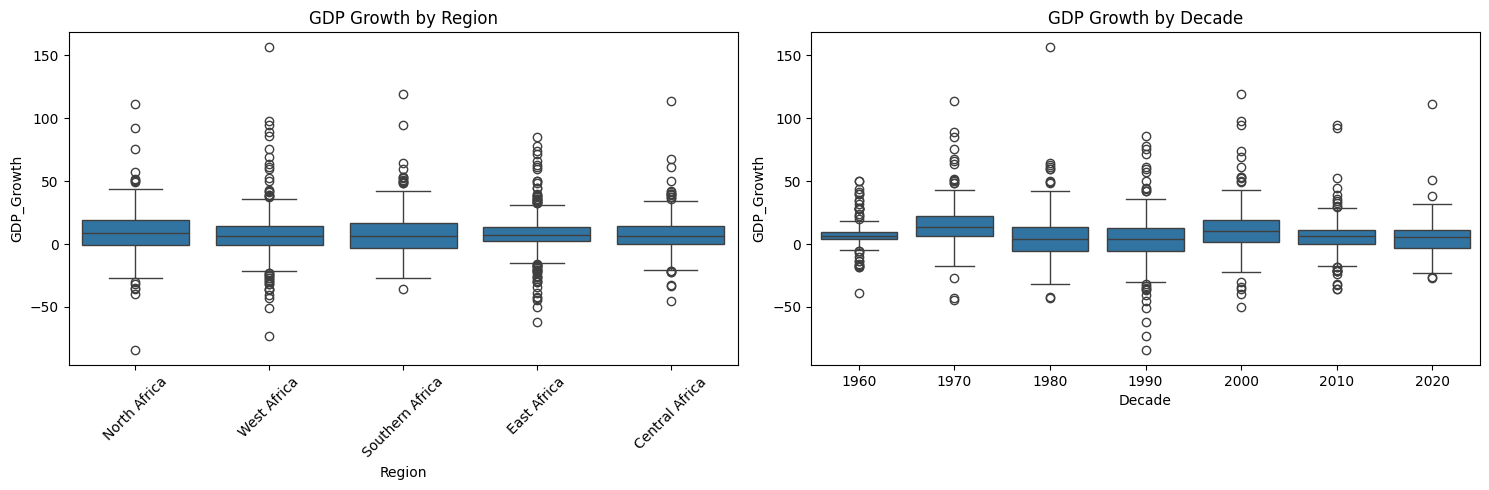

In [19]:
# Data Visualization
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.boxplot(x='Region', y='GDP_Growth', data=df_growth)
plt.title('GDP Growth by Region')
plt.xticks(rotation=45)

plt.subplot(122)
sns.boxplot(x='Decade', y='GDP_Growth', data=df_growth)
plt.title('GDP Growth by Decade')
plt.tight_layout()
plt.show()


In [20]:
# Prepare data for modeling
df_clean = df_growth.dropna(subset=['GDP_Growth'])
features = ['Year', 'Country', 'Region', 'Decade', 'Post_2000']
X = df_clean[features]
y = df_clean['GDP_Growth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline using the properly namespaced CategoryEncoder
preprocessor = gdp_model_utils.CategoryEncoder()
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [21]:
# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'SGD Regression': SGDRegressor(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {'r2': score, 'mse': mse, 'model': model}
    print(f"\n{name}:")
    print(f"R² Score: {score:.4f}")
    print(f"MSE: {mse:.4f}")

    if score > best_score:
        best_score = score
        best_model = model



Linear Regression:
R² Score: -0.0079
MSE: 317.2168

SGD Regression:
R² Score: -53440386186050604017446289408.0000
MSE: 16819567366318830236986605830144.0000

Decision Tree:
R² Score: -0.3054
MSE: 410.8466

Random Forest:
R² Score: 0.1621
MSE: 263.7165


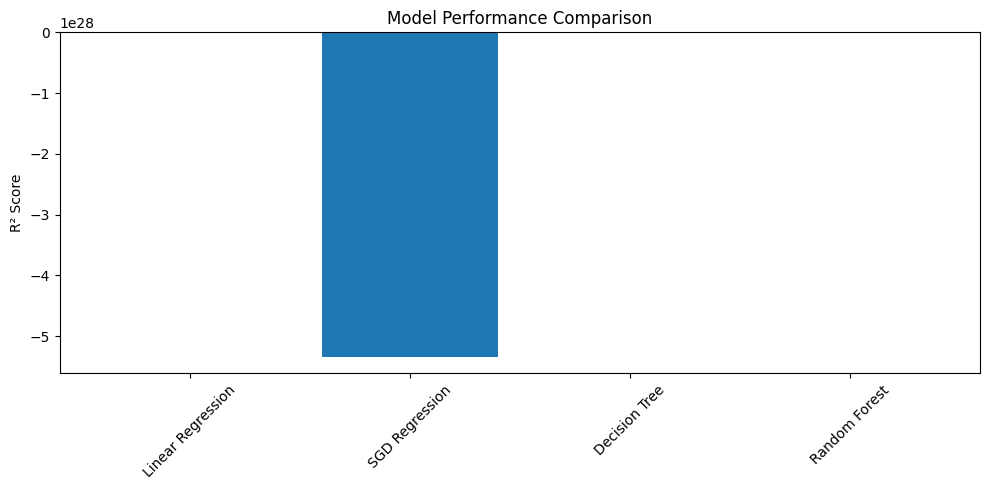

In [22]:
# Save the best model
joblib.dump(best_model, 'best_gdp_growth_model.pkl')
joblib.dump(preprocessor, 'gdp_growth_preprocessor.pkl')

# Plot model comparison
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]
plt.bar(model_names, r2_scores)
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


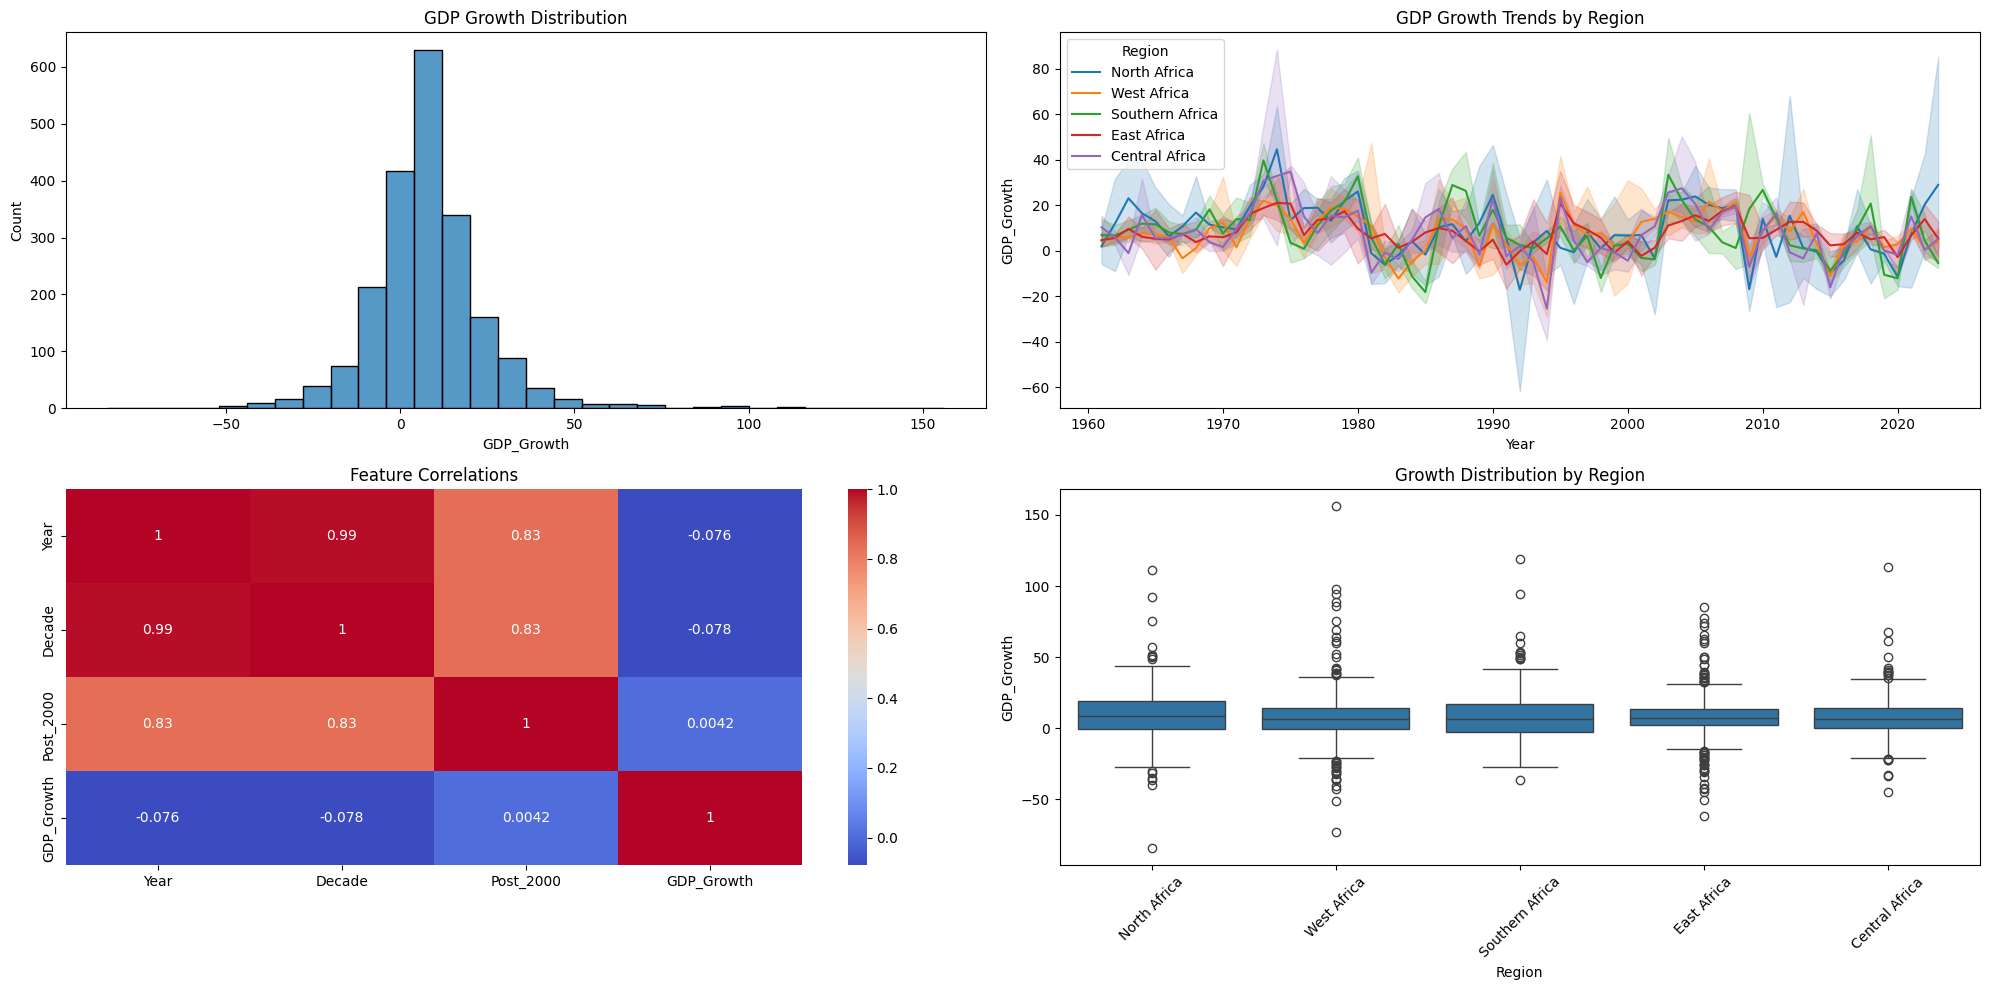

In [23]:
# Enhanced Data Visualization and Analysis
plt.figure(figsize=(20, 10))

# GDP Growth Distribution
plt.subplot(221)
sns.histplot(data=df_growth, x='GDP_Growth', bins=30)
plt.title('GDP Growth Distribution')

# Growth Trends Over Time by Region
plt.subplot(222)
sns.lineplot(data=df_growth, x='Year', y='GDP_Growth', hue='Region')
plt.title('GDP Growth Trends by Region')

# Feature Correlation Analysis
numeric_cols = ['Year', 'Decade', 'Post_2000', 'GDP_Growth']
correlation_matrix = df_growth[numeric_cols].corr()
plt.subplot(223)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')

# Box Plot of Growth by Region
plt.subplot(224)
sns.boxplot(data=df_growth, x='Region', y='GDP_Growth')
plt.xticks(rotation=45)
plt.title('Growth Distribution by Region')
plt.tight_layout()
plt.show()


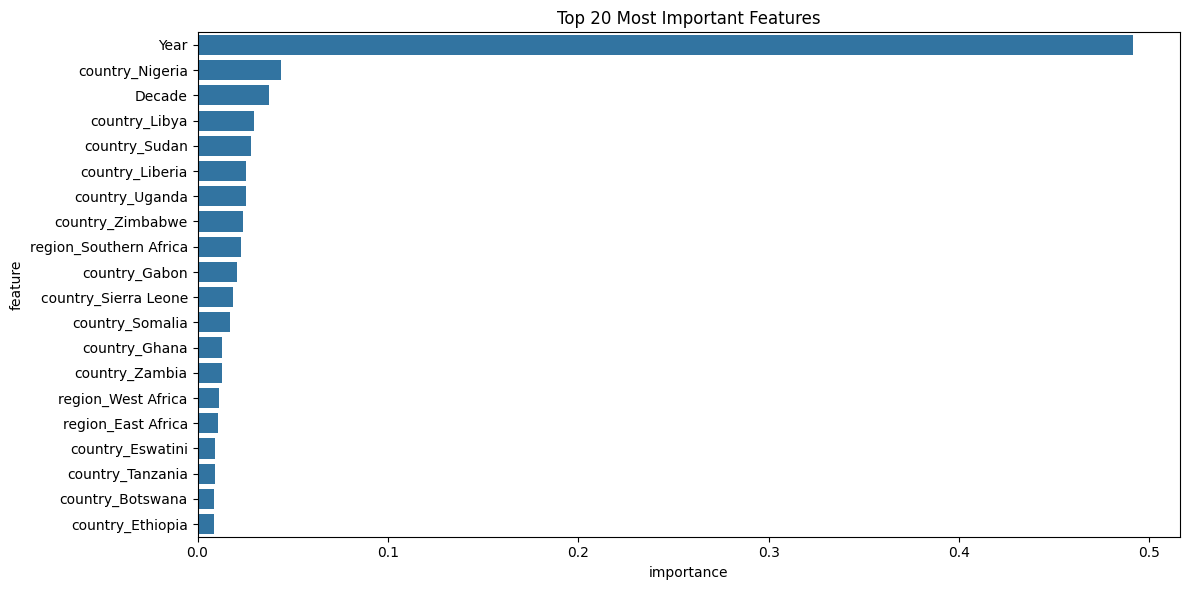

In [24]:
# Feature Standardization
numeric_features = ['Year', 'Decade']
scaler = StandardScaler()
df_clean[numeric_features] = scaler.fit_transform(df_clean[numeric_features])

# Feature Importance Analysis using Random Forest
rf_analyzer = RandomForestRegressor(n_estimators=100, random_state=42)
rf_analyzer.fit(X_train_processed, y_train)

# Get feature names after preprocessing
feature_names = X_train_processed.columns.tolist()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_analyzer.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()


In [25]:
# Enhanced Model Training with Cross-validation
def train_with_cv(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std(),
        'all_scores': cv_scores
    }

# Training with learning curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('R² Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [26]:
# Train and evaluate models with enhanced metrics
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Fit model
    model.fit(X_train_processed, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_processed)
    y_pred_test = model.predict(X_test_processed)

    # Calculate metrics
    train_score = r2_score(y_train, y_pred_train)
    test_score = r2_score(y_test, y_pred_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    # Cross-validation
    cv_results = train_with_cv(model, X_train_processed, y_train)

    # Store results
    results[name] = {
        'model': model,
        'train_r2': train_score,
        'test_r2': test_score,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'cv_mean': cv_results['mean_score'],
        'cv_std': cv_results['std_score']
    }

    print(f"Training R²: {train_score:.4f}")
    print(f"Test R²: {test_score:.4f}")
    print(f"Cross-val R²: {cv_results['mean_score']:.4f} (±{cv_results['std_score']:.4f})")
    print(f"MSE: {test_mse:.4f}")

    # Update best model if current model has better test score
    if test_score > best_score:
        best_score = test_score
        best_model = model
        best_model_name = name
        best_metrics = {
            'r2_score': test_score,
            'mse': test_mse,
            'cv_score': cv_results['mean_score']
        }

print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {best_score:.4f}")

# Save the best model with properly namespaced CategoryEncoder
model_info = {
    'model': best_model,
    'preprocessor': preprocessor,
    'performance': best_metrics,
    'model_name': best_model_name,
    'feature_names': X_train_processed.columns.tolist(),
    'region_mapping': REGION_MAPPING,
    'CategoryEncoder': gdp_model_utils.CategoryEncoder  # Include the class definition
}

# Save as a single pickle file with protocol=4 for better compatibility
joblib.dump(model_info, 'best_gdp_growth_model.pkl', protocol=4)
print(f"\nBest model ({best_model_name}) saved with preprocessor and performance metrics")



Training Linear Regression...
Training R²: 0.0359
Test R²: -0.0079
Cross-val R²: -0.0067 (±0.0228)
MSE: 317.2168

Training SGD Regression...
Training R²: -61550458405912810965849604096.0000
Test R²: -53440386186050604017446289408.0000
Cross-val R²: -39725586428490574000260382720.0000 (±21412572147296909144895782912.0000)
MSE: 16819567366318830236986605830144.0000

Training Decision Tree...
Training R²: 1.0000
Test R²: -0.3054
Cross-val R²: -0.6398 (±0.1697)
MSE: 410.8466

Training Random Forest...
Training R²: 0.8612
Test R²: 0.1621
Cross-val R²: -0.1081 (±0.1107)
MSE: 263.7165

Best performing model: Random Forest
Best R² score: 0.1621

Best model (Random Forest) saved with preprocessor and performance metrics
